<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#DecisionTree" data-toc-modified-id="DecisionTree-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>DecisionTree</a></span></li><li><span><a href="#RandomForest" data-toc-modified-id="RandomForest-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>RandomForest</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#CastBoostRegressor" data-toc-modified-id="CastBoostRegressor-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>CastBoostRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

#  Прогнозирование заказов такси

Онлайн сервис заказа такси собрал исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

**Цель** - построить модель прогнозирования количества заказов такси на следующий час.

По техническому заданию значение метрики *RMSE* на тестовой выборке должно быть не больше 48. В качестве тестовой выборки использовать 10% от исходных данных.

## Подготовка данных

In [ ]:
# загружаем необходимые библиотеки
!pip install catboost
!pip install lightgbm

import pandas as pd
import matplotlib.pyplot as plt
import warnings

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit, cross_val_score

from statsmodels.tsa.seasonal import seasonal_decompose

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

In [2]:
RANDOM = 123

warnings.filterwarnings('ignore')

model_list = []
rmse_score_list = []
best_params = []

In [3]:
#загружаем датасет
try:
    data = pd.read_csv('/datasets/taxi.csv')
except:
    data = pd.read_csv('/Users/amirk/Downloads/taxi.csv')

In [4]:
data

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [6]:
# столбец с датой переведем в формат datetime
data['datetime'] = pd.to_datetime(data['datetime'])

In [7]:
# заменим индекс на столбец datetime
data.rename(index=data['datetime'], inplace=True, copy=False)

In [8]:
# удалим столбец datetime
data.drop('datetime', axis=1, inplace=True)

In [9]:
data

,num_orders
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39


Данные загружены, пропусков нет! Ресемплируем данные по периоду 1 час. Нам важно знать количество заказов за час, а в данных заказы за 10 минут, поэтому применим функцию **sum()**.

In [10]:
data = data.resample('1H').sum()

In [11]:
data

,num_orders
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223


In [12]:
data.index.is_monotonic

True

Данные располложены в хронологическом порядке.    
Данные подготовлены к анализу!

## Анализ

In [13]:
decomposed = seasonal_decompose(data)

<function matplotlib.pyplot.show(close=None, block=None)>

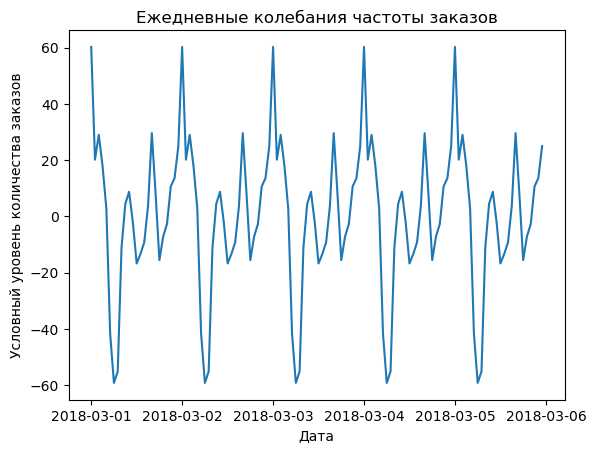

In [14]:
plt.plot(decomposed.seasonal['2018-03-01':'2018-03-05'])
plt.title('Ежедневные колебания частоты заказов')
plt.xlabel('Дата')
plt.ylabel('Условный уровень количества заказов')
plt.show

Видно четкую внутридневную зависимость изменения числа заказов. Рассмотрим более подробно внутридневные колебания. 

<function matplotlib.pyplot.show(close=None, block=None)>

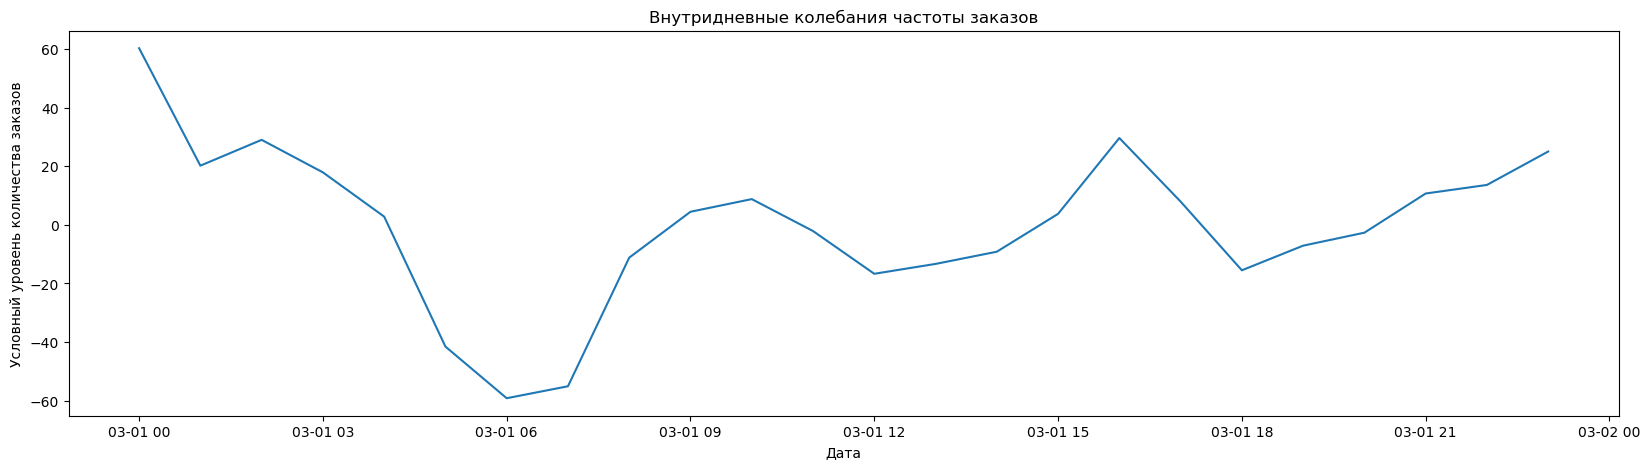

In [15]:
plt.figure(figsize=[20,5])
plt.plot(decomposed.seasonal['2018-03-01'])
plt.title('Внутридневные колебания частоты заказов')
plt.xlabel('Дата')
plt.ylabel('Условный уровень количества заказов')
plt.show

Выявлены достаточно логичные зависимости. Пики заказов такси приходятся на полночь, когда прибывает большое количесвто рейсов, общественный транспорт прекращает свою работу. Затем количество заказов такси снижается, что вероятно связано с уменьшением количества прибывающий рейсов, и минимальное количество заказов приходится на 6 утра. Затем в течение суток отмечается постепенное нарастание количества заказов такси с формированием нескольких пиков в 10ч, 16-17ч и вновь полночь. Добавим данный параметр для прогнозирования

<function matplotlib.pyplot.show(close=None, block=None)>

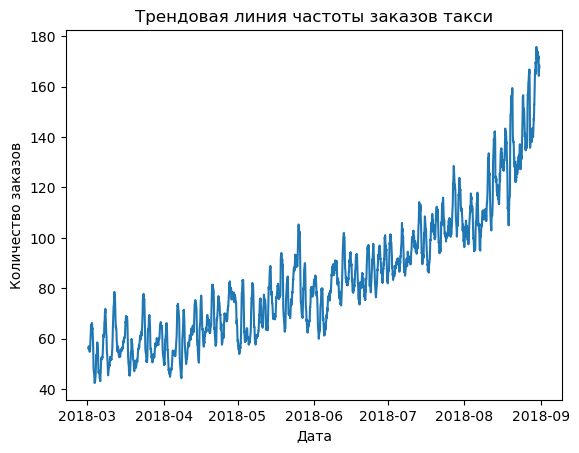

In [16]:
plt.plot(decomposed.trend)
plt.title('Трендовая линия частоты заказов такси')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show

Общий тренд заказов такси указывает на более чем 3х кратное увеличение заказов такcи в период с марта по август 2018г, что может быть связано как с отпускным периодом, так и в целом с увеличением популярности сервиса заказа такси. Данный параметр будет полезной фичей для прогнозирования.

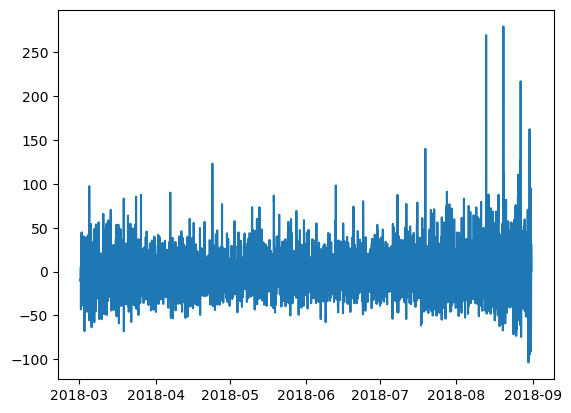

In [17]:
plt.plot(decomposed.resid)

Видны отдельные выбросы, возможно связанные с какими-либо праздниками.

Напишем функцию для добавления фичей для прогнозирования.

In [18]:
def make_features(data, shift_len, roll_len):    
    for i in range(1, shift_len):
        data['shift_{}'.format(i)] = data['num_orders'].shift(i)
    for i in range(2, roll_len):
        data['roll_{}'.format(i)] = data['num_orders'].shift(1).rolling(i).mean()
    data['day_of_week'] = data.index.dayofweek
    #data['month'] = data.index.month
    data['trend'] = decomposed.trend
    data['season'] = decomposed.seasonal
    data.dropna(inplace=True)
    return data

In [19]:
data = make_features(data, 5, 3)

In [20]:
data

,num_orders,shift_1,shift_2,shift_3,shift_4,roll_2,day_of_week,trend,season
2018-03-01 12:00:00,30,96.0,64.0,69.0,34.0,80.0,3,56.125000,-16.721606
2018-03-01 13:00:00,32,30.0,96.0,64.0,69.0,63.0,3,56.145833,-13.352412
2018-03-01 14:00:00,48,32.0,30.0,96.0,64.0,31.0,3,56.958333,-9.191665
2018-03-01 15:00:00,66,48.0,32.0,30.0,96.0,40.0,3,57.000000,3.731832
2018-03-01 16:00:00,43,66.0,48.0,32.0,30.0,57.0,3,56.479167,29.604100
...,...,...,...,...,...,...,...,...,...
2018-08-31 07:00:00,46,35.0,78.0,268.0,99.0,56.5,4,166.208333,-55.104461
2018-08-31 08:00:00,182,46.0,35.0,78.0,268.0,40.5,4,167.791667,-11.212840
2018-08-31 09:00:00,203,182.0,46.0,35.0,78.0,114.0,4,167.229167,4.443581
2018-08-31 10:00:00,191,203.0,182.0,46.0,35.0,192.5,4,167.770833,8.759269


## Обучение

Подготовим данные к загрузке в модель.

In [21]:
X = data.drop('num_orders', axis=1)
y = data['num_orders']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

### LinearRegression

In [22]:
def best_model_lr(X_train, y_train):
    model = LinearRegression()
    model.fit(X_train, y_train)
    model_list.append(model.__class__.__name__)
    rmse_score_list.append(abs(cross_val_score(model,X_train, y_train, 
                           cv = TimeSeriesSplit(n_splits=8), 
                           n_jobs = -1, 
                           scoring = 'neg_root_mean_squared_error').mean()))
    best_params.append(model.get_params)
    print('Значение RMSE = ', abs(cross_val_score(model,X_train, y_train, 
                                               cv = TimeSeriesSplit(n_splits=8), 
                                               n_jobs = -1, 
                                               scoring = 'neg_root_mean_squared_error').mean()))
    return model 

In [23]:
lr = best_model_lr(X_train, y_train)

Значение RMSE =  22.217775256377074


In [24]:
lr.predict(X_train)

array([ 41.93059794,  41.79407291,  46.73953337, ..., 161.1519165 ,
       172.61539967, 165.40936176])

In [25]:
y_train

2018-03-01 12:00:00     30
2018-03-01 13:00:00     32
2018-03-01 14:00:00     48
2018-03-01 15:00:00     66
2018-03-01 16:00:00     43
                      ... 
2018-08-12 23:00:00    185
2018-08-13 00:00:00    160
2018-08-13 01:00:00    273
2018-08-13 02:00:00    437
2018-08-13 03:00:00    168
Freq: H, Name: num_orders, Length: 3952, dtype: int64

In [26]:
def make_pict(model, y_train):    
    fig, ax1 = plt.subplots(figsize=(20,5))
    plt.plot(y_train['2018-03-01':'2018-03-03'], label='Реальные')
    plt.plot(pd.DataFrame(model.predict(X_train), index=y_train.index)['2018-03-01':'2018-03-03'], label='Предсказанные')
    plt.xlabel('Количество заказов', fontsize=16)
    plt.ylabel('Время', fontsize=16)
    plt.title('Количество заказов за 3 дня', fontsize=16)
    plt.legend(fontsize=16)
    plt.show()

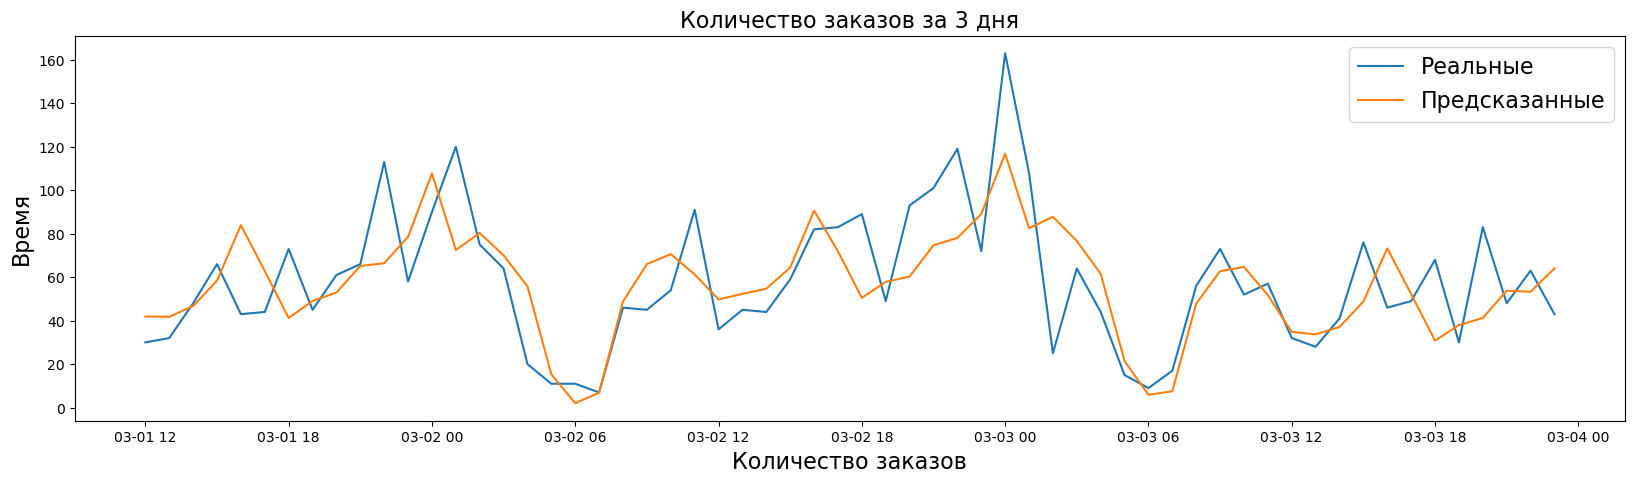

In [27]:
make_pict(lr, y_train)

### DecisionTree

In [29]:
def best_model_dtr(X_train, y_train):
    model = DecisionTreeRegressor()
    params = {'max_depth':range(1,10), 'min_samples_split':range(2,10), 'min_samples_leaf':range(1,10)}
    grid_model = RandomizedSearchCV(model, 
                                    params, 
                                    cv=TimeSeriesSplit(n_splits=8), 
                                    scoring='neg_root_mean_squared_error', 
                                    n_jobs=-1, 
                                    verbose=1, 
                                    random_state=RANDOM)
    grid_model.fit(X_train, y_train)
    model_list.append(model.__class__.__name__)
    rmse_score_list.append(abs(grid_model.best_score_))
    best_params.append(grid_model.best_params_)
    print('Значение RMSE = ', abs(grid_model.best_score_))
    print('Лучшие параметры модели:', grid_model.best_params_)
    return grid_model

In [30]:
dtr = best_model_dtr(X_train, y_train)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
Значение RMSE =  24.231108412574045
Лучшие параметры модели: {'min_samples_split': 7, 'min_samples_leaf': 4, 'max_depth': 5}


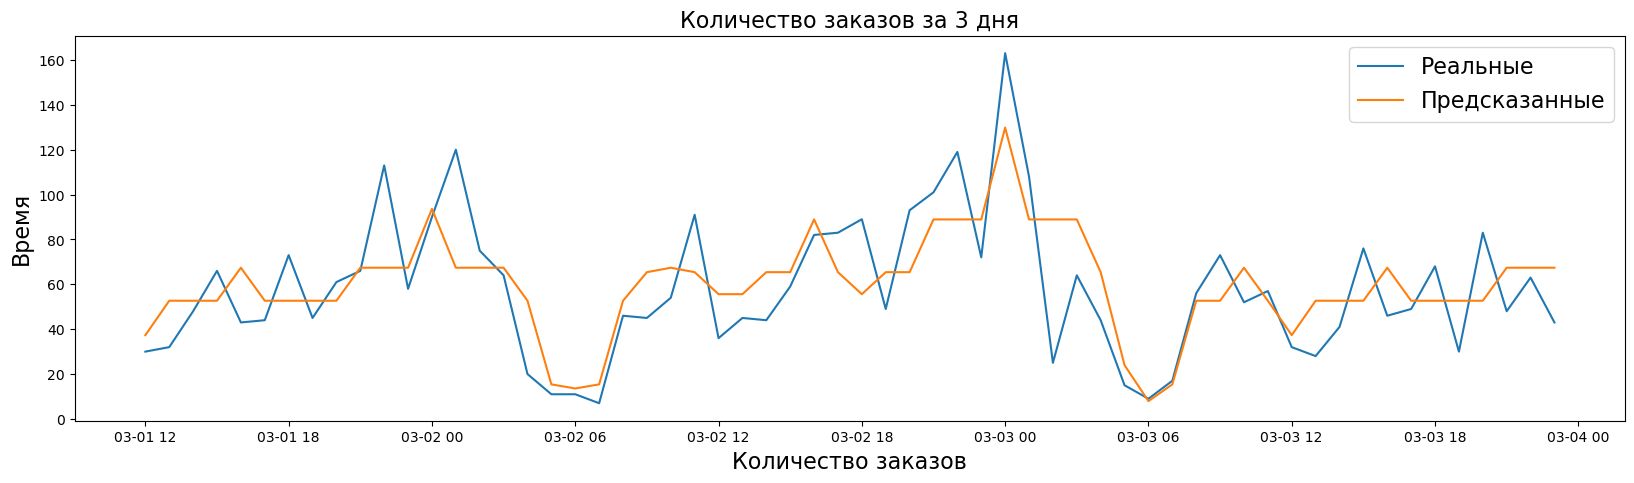

In [31]:
make_pict(dtr, y_train)

### RandomForest

In [32]:
# Для начала найдем лучшие параметры модели на небольшом количестве деревьев 
#с целью экономии времени обучения, а в целом можно и нужно количество деревьев сразу смотреть.
# Затем подберем такой гиперпараметр как количество деревьев
def best_model_rfc(X_train, y_train):
    model = RandomForestRegressor(random_state=RANDOM, n_estimators=10)
    params = {'max_depth':range(1,10), 'min_samples_split':range(2,10), 'min_samples_leaf':range(1,10)}
    grid_model = RandomizedSearchCV(model, 
                                    params, 
                                    cv=TimeSeriesSplit(n_splits=8), 
                                    scoring='neg_root_mean_squared_error', 
                                    n_jobs=-1, 
                                    verbose=1, 
                                    random_state=RANDOM)
    grid_model.fit(X_train, y_train)
    model = RandomForestRegressor(random_state=RANDOM)
    params = {'n_estimators':range(20,300,20), 
              'max_depth':[grid_model.best_params_['max_depth']],
              'min_samples_split':[grid_model.best_params_['min_samples_split']],
              'min_samples_leaf':[grid_model.best_params_['min_samples_leaf']]}
    grid_model = RandomizedSearchCV(model, 
                                    params, 
                                    cv=TimeSeriesSplit(n_splits=8), 
                                    scoring='neg_root_mean_squared_error', 
                                    n_jobs=-1, 
                                    verbose=1, 
                                    random_state=RANDOM)
    grid_model.fit(X_train, y_train)
    model_list.append(model.__class__.__name__)
    rmse_score_list.append(abs(grid_model.best_score_))
    best_params.append(grid_model.best_params_)
    print('Значение RMSE = ', abs(grid_model.best_score_))
    print('Лучшие параметры модели:', grid_model.best_params_)
    return grid_model

In [33]:
rfc = best_model_rfc(X_train, y_train)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
Fitting 8 folds for each of 10 candidates, totalling 80 fits
Значение RMSE =  22.85487887021451
Лучшие параметры модели: {'n_estimators': 240, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_depth': 6}


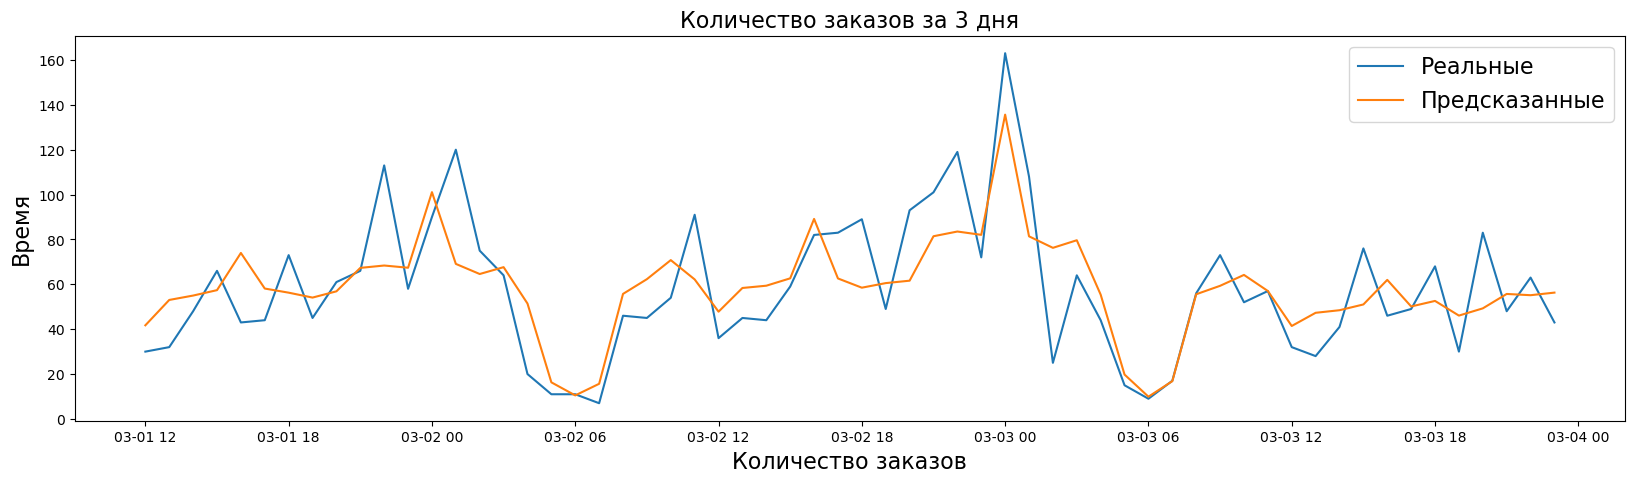

In [34]:
make_pict(rfc, y_train)

### LGBMRegressor

In [35]:
def best_model_lgbm(X_train, y_train):
    model = LGBMRegressor()
    params = {'max_depth':range(1,15), 'min_data_in_leaf':range(1,40)}
    grid_model = RandomizedSearchCV(model, 
                                    params, 
                                    cv=TimeSeriesSplit(n_splits=8), 
                                    scoring='neg_root_mean_squared_error', 
                                    n_jobs=-1, 
                                    verbose=1, 
                                    random_state=RANDOM)
    grid_model.fit(X_train, y_train)
    model_list.append(model.__class__.__name__)
    rmse_score_list.append(abs(grid_model.best_score_))
    best_params.append(grid_model.best_params_)
    print('Значение RMSE = ', abs(grid_model.best_score_))
    print('Лучшие параметры модели:', grid_model.best_params_)
    return grid_model

In [36]:
lgbm = best_model_lgbm(X_train, y_train)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
Значение RMSE =  22.39844363324918
Лучшие параметры модели: {'min_data_in_leaf': 10, 'max_depth': 2}


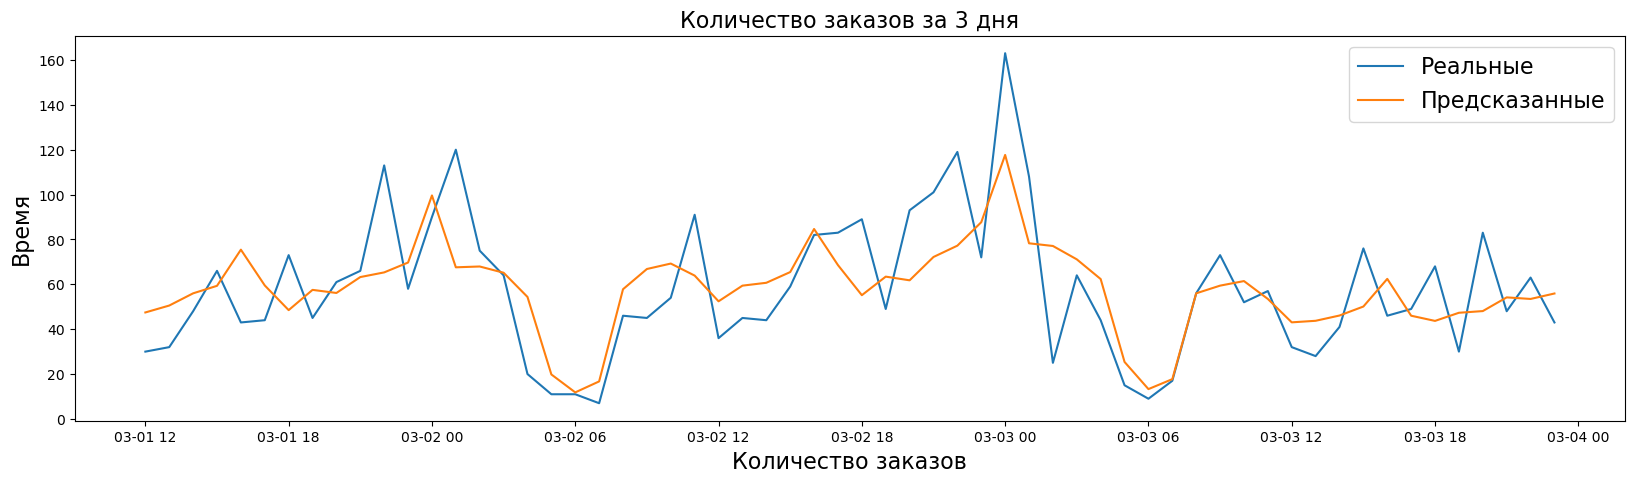

In [37]:
make_pict(lgbm, y_train)

### CastBoostRegressor

In [38]:
def best_model_cbr(X_train, y_train):
    model = CatBoostRegressor(random_state=RANDOM)
    params = {'max_depth':range(2,10), 'iterations':range(20,1000, 20)}
    grid_model = RandomizedSearchCV(model, 
                                    params, 
                                    cv=5, 
                                    scoring='neg_root_mean_squared_error', 
                                    n_jobs=-1, 
                                    verbose=0, 
                                    random_state=RANDOM)
    grid_model.fit(X_train, y_train)
    model_list.append(model.__class__.__name__)
    rmse_score_list.append(abs(grid_model.best_score_))
    best_params.append(grid_model.best_params_)
    print('Значение RMSE = ', abs(grid_model.best_score_))
    print('Лучшие параметры модели:', grid_model.best_params_)
    return grid_model

In [39]:
cbr = best_model_cbr(X_train, y_train)

Learning rate set to 0.330732
0:	learn: 33.3693503	total: 139ms	remaining: 13.7s
1:	learn: 29.2455619	total: 141ms	remaining: 6.91s
2:	learn: 27.0853843	total: 144ms	remaining: 4.64s
3:	learn: 25.3143037	total: 146ms	remaining: 3.5s
4:	learn: 24.1895410	total: 148ms	remaining: 2.82s
5:	learn: 23.5376669	total: 151ms	remaining: 2.36s
6:	learn: 22.9303002	total: 153ms	remaining: 2.04s
7:	learn: 22.5046263	total: 156ms	remaining: 1.79s
8:	learn: 22.2352678	total: 158ms	remaining: 1.6s
9:	learn: 22.1845232	total: 161ms	remaining: 1.45s
10:	learn: 22.0192553	total: 164ms	remaining: 1.32s
11:	learn: 21.9695679	total: 166ms	remaining: 1.22s
12:	learn: 21.8062515	total: 169ms	remaining: 1.13s
13:	learn: 21.7641632	total: 171ms	remaining: 1.05s
14:	learn: 21.7240264	total: 173ms	remaining: 983ms
15:	learn: 21.6937256	total: 176ms	remaining: 923ms
16:	learn: 21.5936222	total: 178ms	remaining: 870ms
17:	learn: 21.5110537	total: 182ms	remaining: 829ms
18:	learn: 21.4660430	total: 185ms	remaining: 

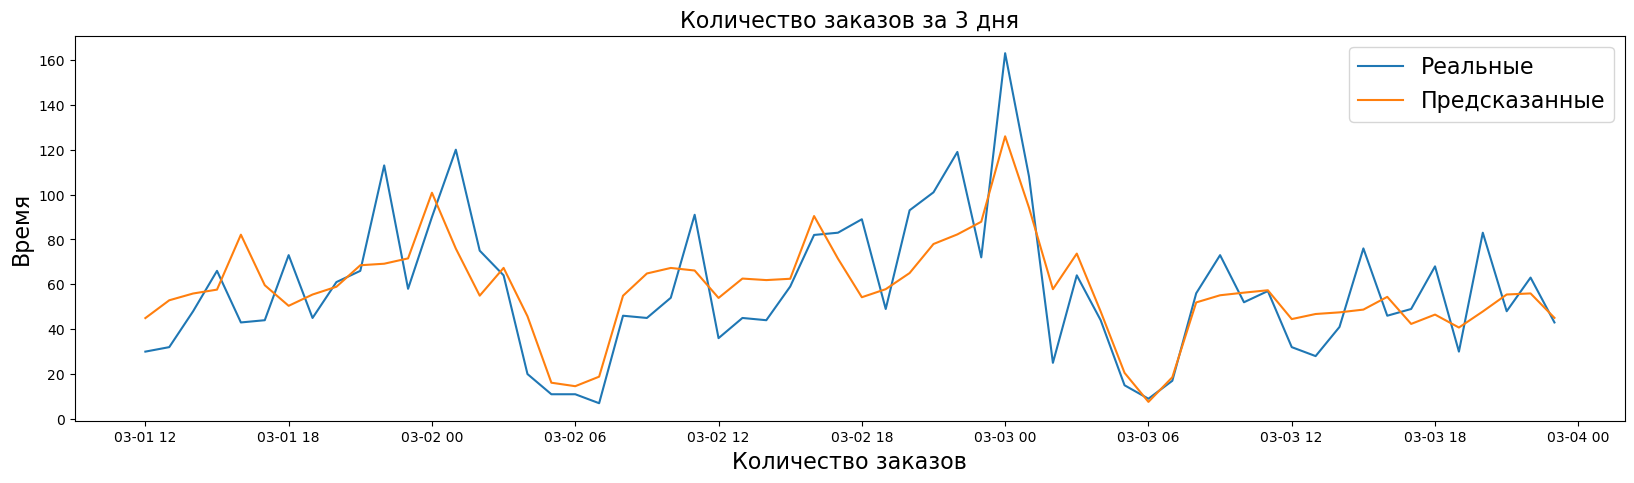

In [40]:
make_pict(cbr, y_train)

In [41]:
# создадим сводную таблицу по результатам теста
top_list_df = pd.DataFrame({'Model':model_list, 
                            'RMSE':rmse_score_list,
                            'Best parameters':best_params }).sort_values(by='RMSE', ascending=True).reset_index(drop=True)
top_list_df

,Model,RMSE,Best parameters
0,LinearRegression,22.217775,<bound method BaseEstimator.get_params of Line...
1,LGBMRegressor,22.398444,"{'min_data_in_leaf': 10, 'max_depth': 2}"
2,CatBoostRegressor,22.598809,"{'max_depth': 3, 'iterations': 100}"
3,RandomForestRegressor,22.854879,"{'n_estimators': 240, 'min_samples_split': 9, ..."
4,DecisionTreeRegressor,24.231108,"{'min_samples_split': 7, 'min_samples_leaf': 4..."


В ходе исследования нами было оценено 5 моделей для прогнозирования количества заказов такси на следующий час. Наилучший показатель RMSE оказался у модели LinearRegression. Именно данная модель будет применяться для прогнозирования заказов!

| Модель                | RMSE               | 
| :---:                 |    :----:          | 
| **LinearRegression**      | **22.22**              |
| LGBMRegressor | 22.40|
| CatBoostRegressor | 22.60 |
| RandomForestRegressor | 22.85 |
| DecisionTreeRegressor | 24.23              | 


Проверим работу модели на тестовых данных!

## Тестирование

In [43]:
prediction = lr.predict(X_test)
final_rmse = mean_squared_error(y_test, prediction, squared=False)
final_rmse

40.37472804262914

Лучшей моделью для прогнозирования количества заказов такси признана модель **LinearRegression**. Итоговое значение RMSE на тестовых данных составило 40.37. Модель успешно прошла тестирование!

## Выводы

Онлайн сервису заказа такси была необходима  модель прогнозирования заказов такси на следующий час для привлечения  большего количества водителей в период пиковой нагрузки. 

По техническому заданию значение метрики RMSE на тестовой выборке должно было быть не больше 48. В качестве тестовой выборки использовалось 10% от исходных данных.

В ходе исследования было выполнено:
- загрузка данных;
- переопределение типов данных в столбцах;
- ресемплирование временного ряда;
- оценка сезонных зависимостей и трендовой линии;
- добавление новых признаков;
- разделение данных на тренировочную и тестовую выборки;
- обучение моделей.

В ходе исследования нами было оценено 5 моделей для прогнозирования количества заказов такси на следующий час. Наилучший показатель RMSE оказался у модели LinearRegression. Именно данная модель будет применяться для прогнозирования заказов!

| Модель                | RMSE               | 
| :---:                 |    :----:          | 
| **LinearRegression**      | **22.22**              |
| LGBMRegressor | 22.40|
| CatBoostRegressor | 22.60 |
| RandomForestRegressor | 22.85 |
| DecisionTreeRegressor | 24.23              | 

Лучшей моделью для прогнозирования количества заказов такси признана модель **LinearRegression**. Итоговое значение RMSE на тестовых данных составило 40.37. 
